In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression

# Question 1

In [ ]:
#1. load data and add column 'color'
filepath='../hw3/data_banknote_authentication.txt'
data = pd.read_csv(filepath, sep=",", header=None)
data.columns = ["variance", "skewness", "curtosis", "entropy",'class']
data['color']=data['class'].apply(lambda x: 'green' if x == 0 else 'red')
data.head(2)

,variance,skewness,curtosis,entropy,class,color
0,3.6216,8.6661,-2.8073,-0.44699,0,green
1,4.5459,8.1674,-2.4586,-1.46210,0,green


In [ ]:
data.tail(2)

,variance,skewness,curtosis,entropy,class,color
1370,-3.5637,-8.38270,12.3930,-1.2823,1,red
1371,-2.5419,-0.65804,2.6842,1.1952,1,red


In [ ]:
#2. compute mean & std; round to 2 decimal places
zero=data.loc[data['class']==0].describe().loc[['mean','std']].round(2)
one=data.loc[data['class']==1].describe().loc[['mean','std']].round(2)
full = data.describe().loc[['mean','std']].round(2)

zero=zero[['variance','skewness','curtosis','entropy']]
one=one[['variance','skewness','curtosis','entropy']]
full=full[['variance','skewness','curtosis','entropy']]

print(zero,'\n\n',one,'\n\n',full)

      variance  skewness  curtosis  entropy
mean      2.28      4.26      0.80    -1.15
std       2.02      5.14      3.24     2.13 

       variance  skewness  curtosis  entropy
mean     -1.87     -0.99      2.15    -1.25
std       1.88      5.40      5.26     2.07 

       variance  skewness  curtosis  entropy
mean      0.43      1.92      1.40    -1.19
std       2.84      5.87      4.31     2.10


#### Answer 3: F1 and F2 mean for red bank notes is significantly lower; f3 values are substantially higher

# Exploratory Analysis

In [ ]:
# question 1 - train test split
y = data['color']
x = data.drop(['color'],axis=1)

#train test split
X_train, X_test, y_train, y_test = split(x,y, test_size=0.5, train_size=0.5, random_state=105, shuffle=True,stratify=y)

Text(0.5, 1.0, 'Good and Fake Bills')

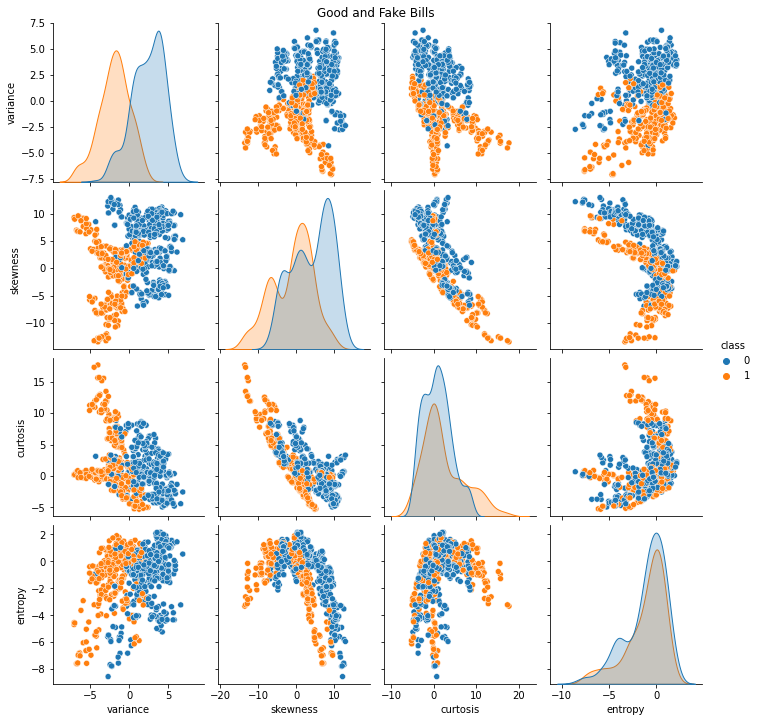

In [ ]:
#visualization using pairplot
g=sns.pairplot(X_test,hue='class')
g.fig.suptitle('Good and Fake Bills',y=1.0)

In [ ]:
# repeating train test split to remove color class from data to prevent train-test leakage
y = data['class']
x = data.drop(['color','class'],axis=1)

#train test split
X_train, X_test, y_train, y_test = split(x,y, test_size=0.5, train_size=0.5, random_state=0, shuffle=True,stratify=y)

In [ ]:
#question 3 - manual implementation of detection rules with tresholds
xtest_copy = X_test.copy()

def fakeDetection(variance,skewness,curtosis):
    if (variance < -1) and (skewness < -7) and (curtosis > 9):
        return 1  #fake
    else:
        return 0 #good

xtest_copy['predictions']=xtest_copy.apply(lambda x: fakeDetection(x.variance,x.skewness,x.curtosis),axis=1)
xtest_copy.predictions.value_counts()

0    649
1     37
Name: predictions, dtype: int64

In [ ]:
#Questions 4-6
def getMetrics(y_test,y_predictions):
    TN, FP, FN, TP= confusion_matrix(y_test, y_predictions).ravel()
    TPR = TP/(TP + FN)
    TNR = TN/(TN + FP)
    Accuracy = (TP+TN)/(TP+TN+FP+FN)
    metrics = pd.DataFrame(data = [TN, FP, FN, TP, Accuracy, TPR, TNR],
             index=['TN', 'FP', 'FN', 'TP', 'Accuracy', 'TPR', 'TNR']).transpose()
    return metrics

getMetrics(y_train,xtest_copy.predictions)

,TN,FP,FN,TP,Accuracy,TPR,TNR
0,361.0,20.0,288.0,17.0,0.55102,0.055738,0.947507


#### Answer 6: Accuracy > 50% and better than coin-flipping. Comparing the TNR with the TPR shows that the model is better at detecting real bills

# Classification

In [ ]:
# KNN implementation
y = data['class']
x = data.drop(['color','class'],axis=1)

#train test split
X_train, X_test, y_train, y_test = split(x,y, test_size=0.5, train_size=0.5, random_state=105, shuffle=True,stratify=y)

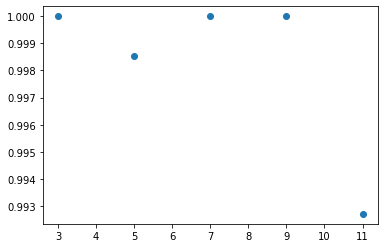

In [ ]:
#get knn classification accuracy for k=n
def getKnnClassification_Accuracy(n_neigh,X_train,y_train,X_test,y_test):
    neigh = knn(n_neighbors=n_neigh)
    neigh.fit(X_train, y_train)
    predictions = neigh.predict(X_test)
    acc=getMetrics(y_test,predictions).Accuracy[0]
    return n_neigh,acc

knn_accuracy = []

#get knn classification accuracy for k= 3,5,7,9,11
for i in (3,5,7,9,11):
    knn_accuracy.append(getKnnClassification_Accuracy(i,X_train,y_train,X_test,y_test))

#visualize using scatterplot
plt.scatter(*zip(*knn_accuracy))
plt.show()

In [ ]:
#print accuracy values
knn_accuracy

[(3, 1.0),
 (5, 0.9985422740524781),
 (7, 1.0),
 (9, 1.0),
 (11, 0.9927113702623906)]

#### Answer 2: the Optimum lies between k=7 and k=9

In [ ]:
def getKnnClassification_Metrics(n_neigh,X_train,y_train,X_test,y_test):
    neigh = knn(n_neighbors=n_neigh)
    neigh.fit(X_train, y_train)
    predictions = neigh.predict(X_test)
    metrics=getMetrics(y_test,predictions)
    return metrics

metrics_comparison = getKnnClassification_Metrics(7,X_train,y_train,X_test,y_test)

metrics_comparison=metrics_comparison.append(getMetrics(y_test,xtest_copy.predictions))
metrics_comparison.index = ['KNN','Manual Clf']
metrics_comparison

,TN,FP,FN,TP,Accuracy,TPR,TNR
KNN,381.0,0.0,0.0,305.0,1.000000,1.000000,1.000000
Manual Clf,363.0,18.0,286.0,19.0,0.556851,0.062295,0.952756


#### Answer 4: The comparison shows that knn classifier performs better with up to 100% accuracy vs. 55%. This also applies for all other metrics

In [ ]:
#Question 5

#detection for BUID with manual classifier
print('manual implementation: ',fakeDetection(9,0,6),'\n')

#detection for BUID with best k knn
neigh = knn(n_neighbors=7)
neigh.fit(X_train, y_train)
print('knn best: ',neigh.predict([[9,0,6,6]])[0])

manual implementation:  0 

knn best:  0


In [ ]:
# drop column n; classify and get Accuracy
def featureSelection(data,drop_col):
    y = data['class']
    x = data.drop(['color','class',drop_col],axis=1)
    X_train, X_test, y_train, y_test = split(x,y, test_size=0.5, train_size=0.5, random_state=0, shuffle=True,stratify=y)
    return getKnnClassification_Accuracy(7,X_train,y_train,X_test,y_test)[1]

#call function to sequentially drop one column and compute accuracy ['variance', 'skewness', 'curtosis', 'entropy']
for i in data.columns[:4]:
    print('drop',i,'to get accuracy of:',featureSelection(data,i))

print('Accuracy with all 4 features:',getKnnClassification_Accuracy(5,X_train,y_train,X_test,y_test)[1])

drop variance to get accuracy of: 0.956268221574344
drop skewness to get accuracy of: 0.9810495626822158
drop curtosis to get accuracy of: 0.967930029154519
drop entropy to get accuracy of: 0.9985422740524781
Accuracy with all 4 features: 0.9985422740524781


#### Finding 2: Dropping columns does not improve the accuracy

#### Finding 3: The greatest accuracy loss was caused when dropping the attribute 'variance'

#### Finding 4: The smalles accuracy loss was cuased when dropping the attribute 'entropy'

In [ ]:
#define and call method for linear regression classification
def getLogisticRegression(X_train, X_test, y_train):
    model = LogisticRegression(random_state=0).fit(X_train, y_train)
    return model.predict(X_test)

#get predictions
LR_predictions = getLogisticRegression(X_train, X_test, y_train)

#get confusion matrix & accuracy metrics
LR_results=getMetrics(y_test,LR_predictions).append(metrics_comparison)
LR_results.index = ['Logistic Regression','KNN','Manual Clf']
LR_results

,TN,FP,FN,TP,Accuracy,TPR,TNR
Logistic Regression,375.0,6.0,2.0,303.0,0.988338,0.993443,0.984252
KNN,381.0,0.0,0.0,305.0,1.000000,1.000000,1.000000
Manual Clf,363.0,18.0,286.0,19.0,0.556851,0.062295,0.952756


In [ ]:
print('logistic regression:',getLogisticRegression(X_train,[[9,0,6,6]],y_train,)[0])
print('knn best:',neigh.predict([[9,0,6,6]])[0])

logistic regression: 0
knn best: 0


In [ ]:
# drop column n and get test-train split
def featureSelectionLrClf(data,drop_col):
    y = data['class']
    x = data.drop(['color','class',drop_col],axis=1)
    X_train, X_test, y_train, y_test = split(x,y, test_size=0.5, train_size=0.5, random_state=105, shuffle=True,stratify=y)
    return X_train, X_test, y_train, y_test

for i in data.columns[:4]:
    X_train, X_test, y_train,y_test=featureSelectionLrClf(data,i)
    LR_predictions = getLogisticRegression(X_train, X_test, y_train)
    print('drop',i,'to get',getMetrics(y_test,LR_predictions)[['Accuracy']])

print('\n accuracy with all fetures',LR_results.iloc[0][4])

drop variance to get    Accuracy
0  0.800292
drop skewness to get    Accuracy
0  0.906706
drop curtosis to get    Accuracy
0  0.879009
drop entropy to get    Accuracy
0  0.988338

 accuracy with all fetures 0.9883381924198251


#### Finding 2:  the accuracy did not increase when dropping the attributes

#### Finding 3: Removing Feature 'variance' caused the greatest loss when being removed

#### Finding 4: Removing the feature 'Entropy' caused the least loss

#### Finding 5: In both cases (KNN & Logistic Regression) the relative accuracy loss for the features was loss(variance) > loss(curtosis) > loss(skewness) > loss(entropy) - However, the extend of the loss was higher in the case of Logistic regression (-10%) compared to the loss of KNN Classifiers (-5%)